In [4]:
import daspi as dsp
import matplotlib.pyplot as plt
DPI = 120
dsp.__version__

'0.5.0'

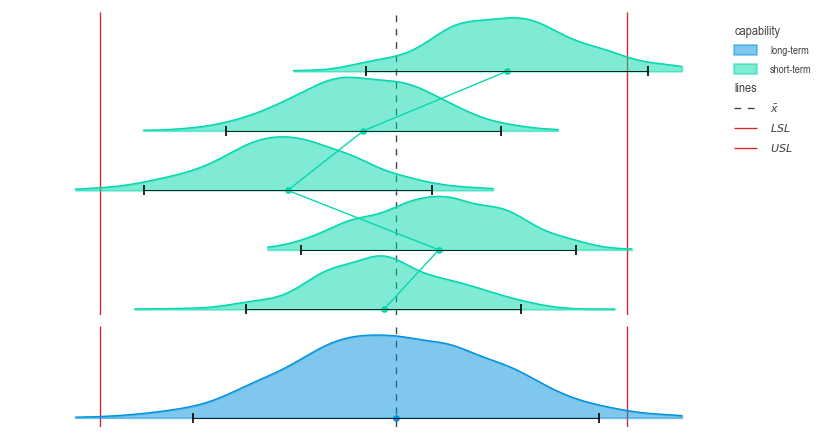

In [5]:
import numpy as np
import pandas as pd
from scipy import stats
from typing import Any
from typing import Dict

import seaborn as sns
sns.displot

np.random.seed(3)
N_SAMPLES = 500
HEIGHT = 0.9
means = np.random.random(5)-0.5
df_batch = pd.DataFrame()

for i, mean in enumerate(means):
    pos = i
    data = pd.DataFrame({
        'capability': 'short-term',
        'position': pos,
        'values': stats.norm.rvs(size=N_SAMPLES, loc=mean, scale=0.2)})
    df_batch = pd.concat([df_batch, data], axis=0, ignore_index=True)
df_tot = pd.DataFrame({
    'capability': 'long-term',
    'position': 0,
    'mean': '0',
    'values': df_batch['values']})

chart = dsp.JointChart(
        source=pd.concat([df_batch, df_tot]),
        target='values',
        feature='position',
        hue='capability',
        ncols=1,
        nrows=2,
        height_ratios=[3, 1],
        target_on_y=False,
        sharex=True,
        sharey=False,
    ).stripes(
        stripes=[dsp.StripeLine(
            r'\bar x', df_tot['values'].mean(), orientation='vertical')],
        spec_limits=(-0.75, 0.75),
    ).label(
    )

def axes_settings(ax) -> None:
    ax.xaxis.set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set(ylim=(-0.1, None), xlim=(-1, 1))

kw_base: Dict[str, Any] = dict(
    feature='position',
    target='values',
    target_on_y=False,
    ax=chart.axes[0, 0],
    color=dsp.COLOR.PALETTE[1])
kw_kde: Dict[str, Any] = dict(
    height=HEIGHT,
    fill=True,
    ignore_feature=False)
kw_spread: Dict[str, Any] = dict(
    marker='o',
    agreement=4,
)
dsp.CenterLocation(source=df_batch, center_points=False, **kw_base)()
for pos, group in df_batch.groupby('position'):
    dsp.GaussianKDE(source=group, f_base=pos, **(kw_base | kw_kde))()
    dsp.SpreadWidth(source=group, **(kw_base | kw_spread))()

kw_base['ax'] = chart.axes[1, 0]
kw_base['color'] = color=dsp.COLOR.PALETTE[0]
dsp.GaussianKDE(source=df_tot, f_base=0, **(kw_base | kw_kde))()
dsp.SpreadWidth(source=df_tot, **(kw_base | kw_spread))()

for ax in chart.axes.flat:
    axes_settings(ax)

In [6]:
pos, data = next(iter(df_batch.groupby('position')))
estimation = dsp.ProcessEstimator(data['values'], -0.75, 0.75)
estimation.Z_lt

2.0395762631892227

In [7]:
estimation = dsp.ProcessEstimator(df_tot['values'], -0.75, 0.75)
estimation.Z

2.281028062704287

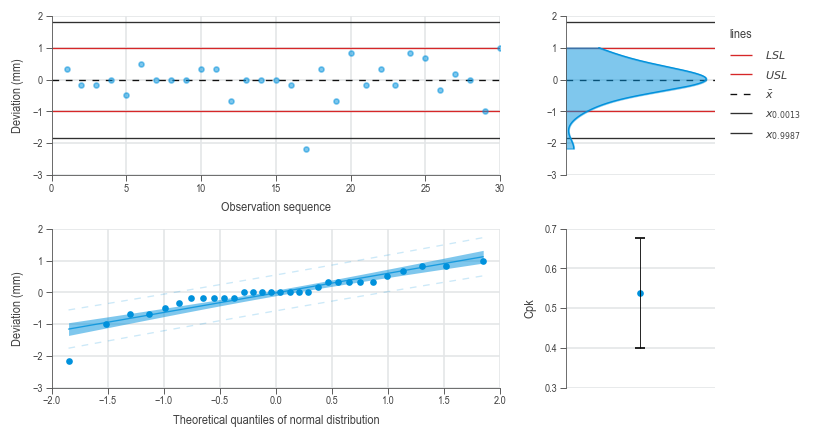

In [8]:
df = dsp.load_dataset('salt_sticks')
spec_limits = tuple(df.loc[0, ['lsl', 'usl']])
target_label = 'Deviation (mm)'

dsp.JointChart(
        source=df,
        target='deviation',
        feature='',
        ncols=2,
        nrows=2,
        width_ratios=[3, 1],
    ).plot(
        dsp.Scatter
    ).plot(
        dsp.GaussianKDE,
        show_density_axis=False,
    ).plot(
        dsp.Probability,
        dist='norm'
    ).plot(
        dsp.CapabilityConfidenceInterval,
        spec_limits=spec_limits,
        n_groups=1,
        kind='cpk'
    ).stripes(
        mean=(
            True, True,
            False, False),
        control_limits=(
            True, True,
            False, False),
        spec_limits=(
            spec_limits, spec_limits,
            (None, None), (None, None)),
    ).label(
        target_label=(
            target_label, '',
            target_label, 'Cpk'),
        feature_label=(
            'Observation sequence', '', 
            'Theoretical quantiles of normal distribution', ''),
    )


In [9]:
dsp.estimate_capability_confidence(df['deviation'], *spec_limits)

(0.538570634462214, 0.40099446634237323, 0.6761468025820547)

In [10]:
limits = tuple(df.loc[0, ['lsl', 'usl']])
estimation = dsp.ProcessEstimator(df['deviation'], *limits)
estimation.describe()

c:\Appl\Python\.virtualenvs\DataScience-DY0ovQ8g-3.11\Lib\site-packages\scipy\stats\_continuous_distns.py:6617: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


n_samples          30
n_missing           0
n_ok               29
n_nok               1
n_errors            0
mean        -0.016667
median            0.0
std          0.608607
sem          0.111116
excess         4.4555
p_excess     0.003562
skew        -1.416563
p_skew       0.002881
dist         logistic
p_ad         0.011121
lcl         -1.842487
ucl          1.809154
strategy         norm
lsl              -1.0
usl               1.0
cp           0.547699
cpk          0.538571
Z            1.615712
Z_lt         0.115712
dtype: object

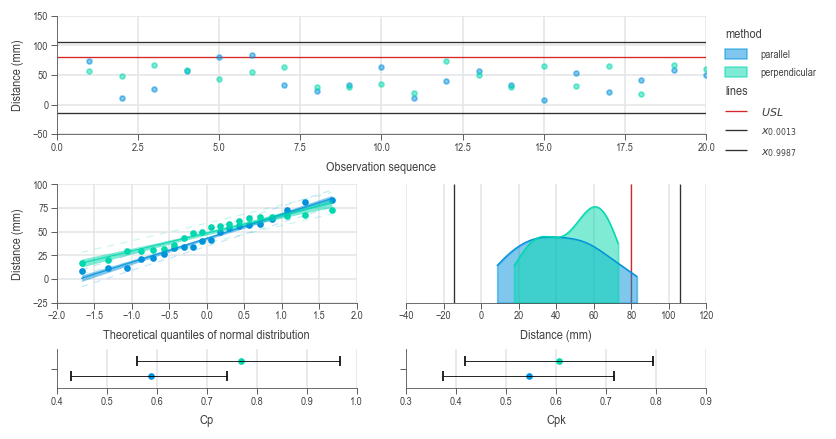

In [11]:
df = dsp.load_dataset('drop_card')
spec_limits = None, float(df.loc[0, 'usl'])
no_limits = (None, None)
target = 'distance'
target_label = 'Distance (mm)'

chart = dsp.JointChart(
        source=df,
        target=target,
        feature='',
        hue='method',
        mosaic=('rr', 'pd', 'ck',),
        height_ratios=[3, 3, 1],
        dodge=(False, False, False, True, True),
        target_on_y=(True, True, False, False, False)
    ).plot(
        dsp.Scatter
    ).plot(
        dsp.Probability,
        dist='norm'
    ).plot(
        dsp.GaussianKDE,
        show_density_axis=False,
    ).plot(
        dsp.CapabilityConfidenceInterval,
        spec_limits=(0, spec_limits[1]),
        n_groups=1,
        kind='cp'
    ).plot(
        dsp.CapabilityConfidenceInterval,
        spec_limits=spec_limits,
        n_groups=1,
        kind='cpk'
    ).stripes(
        mean=False,
        control_limits=(True, False, True, False, False),
        spec_limits=(spec_limits, no_limits, spec_limits, no_limits, no_limits),
    ).label(
        target_label=(target_label, target_label, target_label, 'Cp', 'Cpk'),
        feature_label=(
            'Observation sequence',
            'Theoretical quantiles of normal distribution', '',
            '', ''),
    )

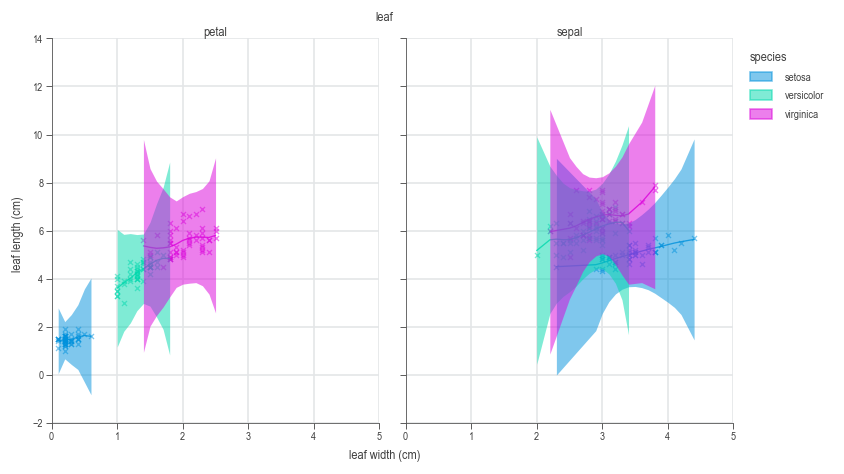

In [2]:
import daspi as dsp
df = dsp.load_dataset('iris')

chart = dsp.MultipleVariateChart(
        source=df,
        target='length',
        feature='width',
        hue='species',
        col='leaf',
        markers=('x',)
    ).plot(
        dsp.Scatter
    ).plot(
        dsp.LowessLine, fraction=0.3, show_ci=True
    ).label(
        feature_label='leaf width (cm)',
        target_label='leaf length (cm)',
    )

# chart.save('docs/img/iris_contour_size-leaf-species.png', dpi=DPI)

[0.11690405 0.12310312 0.20301714 0.10218205 0.05964212 0.06943459
 0.0583702  0.10548378 0.11190261 0.13032529 0.11737137 0.11697857
 0.06149375 0.13063797 0.12836588 0.1159398  0.11696622 0.13246678
 0.06050236 0.06009427 0.13052914 0.22218647 0.1041924  0.11770766
 0.13078273 0.12918722 0.07172343 0.10904832 0.05779561 0.13063582
 0.06789658 0.11776235 0.19178943 0.12934471 0.11765679 0.1044519
 0.11709801 0.13174229 0.14761906 0.13067786 0.30175726 0.13039774
 0.09507671 0.13064381 0.06680685 0.12111632 0.12942887 0.09985266
 0.09792264 0.06206538 0.14510791 0.11645415 0.06345421 0.08799464
 0.12298953 0.09178779 0.13114414 0.05964557 0.12721902 0.11868243
 0.06699747 0.11622982 0.11795513 0.1162586  0.09534239 0.12982838
 0.11567927 0.12602918 0.16164532 0.12803781 0.12898309 0.06092595
 0.06066206 0.13062989 0.11213086 0.05795622 0.13831041 0.10550459
 0.13076162 0.12475869 0.13016899 0.1182989  0.13077734 0.10551884
 0.09022991 0.12910826 0.11901369 0.21151652 0.11566953 0.11865

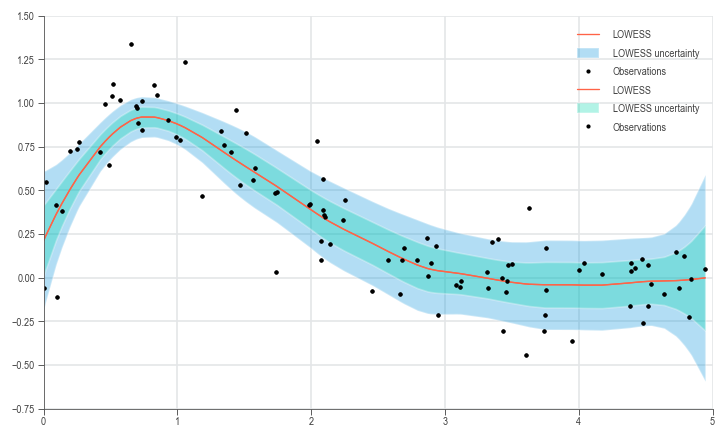

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import daspi as dsp

np.random.seed(1)

def lowess(x, y, f=1./3.):
    """
    Basic LOWESS smoother with uncertainty. 
    Note:
        - Not robust (so no iteration) and
             only normally distributed errors. 
        - No higher order polynomials d=1 
            so linear smoother.
    """
    # get some paras
    xwidth = f*(x.max()-x.min()) # effective width after reduction factor
    N = len(x) # number of obs
    # Don't assume the data is sorted
    order = np.argsort(x)
    # storage
    y_sm = np.zeros_like(y)
    y_stderr = np.zeros_like(y)
    # define the weigthing function -- clipping too!
    tricube = lambda d : np.clip((1- np.abs(d)**3)**3, 0, 1)
    # run the regression for each observation i
    for i in range(N):
        dist = np.abs((x[order][i]-x[order]))/xwidth
        w = tricube(dist)
        # form linear system with the weights
        A = np.stack([w, x[order]*w]).T
        b = w * y[order]
        ATA = A.T.dot(A)
        ATb = A.T.dot(b)
        # solve the syste
        sol = np.linalg.solve(ATA, ATb)
        # predict for the observation only
        yest = A[i].dot(sol)# equiv of A.dot(yest) just for k
        place = order[i]
        y_sm[place]=yest 
        sigma2 = (np.sum((A.dot(sol) -y [order])**2)/N )
        # Calculate the standard error
        y_stderr[place] = np.sqrt(sigma2 * 
                                A[i].dot(np.linalg.inv(ATA)
                                                    ).dot(A[i]))
    return y_sm, y_stderr

# make some data
x = 5*np.random.random(100)
y = np.sin(x) * 3*np.exp(-x) + np.random.normal(0, 0.2, 100)
order = np.argsort(x)
#run it
y_sm, y_std = lowess(x, y, f=1./5.)
# plot it
plt.plot(x[order], y_sm[order], color='tomato', label='LOWESS')
plt.fill_between(x[order], y_sm[order] - 1.96*y_std[order],
                 y_sm[order] + 1.96*y_std[order], alpha=0.3, label='LOWESS uncertainty')
plt.plot(x, y, 'k.', label='Observations')
plt.legend(loc='best')
#run it
y_sm, y_std = lowess(x, y, f=1./5.)
# plot it
plt.plot(x[order], y_sm[order], color='tomato', label='LOWESS')
plt.fill_between(x[order], y_sm[order] - y_std[order],
                 y_sm[order] + y_std[order], alpha=0.3, label='LOWESS uncertainty')
plt.plot(x, y, 'k.', label='Observations')
plt.legend(loc='best')

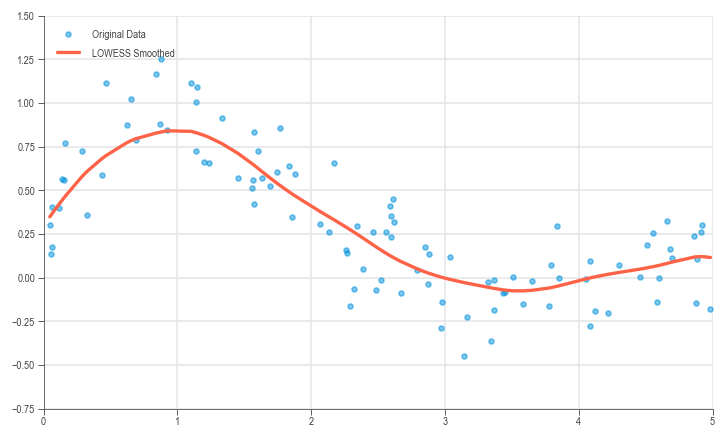

In [24]:

import numpy as np

def prepare_data(x, y):
    """Prepare the data by converting inputs to numpy arrays."""
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

def tricube_weights(x, xi, bandwidth):
    """Calculate weights using the tricube kernel."""
    u = np.abs((x - xi) / bandwidth)
    weights = np.where(u <= 1, (1 - u**3)**3, 0)
    return weights

def lowess(x, y, bandwidth, fraction=0.5):
    """Perform LOWESS smoothing on the data."""
    x, y = prepare_data(x, y)
    n = len(x)
    smoothed = np.zeros(n)

    for i in range(n):
        # Calculate weights for the current x value
        weights = tricube_weights(x, x[i], bandwidth)
        
        # Perform weighted linear regression
        W = np.diag(weights)
        X = np.vstack((np.ones(n), x)).T  # Design matrix
        beta = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)  # Calculate coefficients
        
        # Predict the smoothed value
        smoothed[i] = beta[0] + beta[1] * x[i]

    return smoothed


# Sample data
x = np.sort(5*np.random.random(100))
y = np.sin(x) * 3*np.exp(-x) + np.random.normal(0, 0.2, 100)

# Apply LOWESS
bandwidth = 1
smoothed_y = lowess(x, y, bandwidth)

# Plotting (optional)
import matplotlib.pyplot as plt

plt.scatter(x, y, label='Original Data', alpha=0.5)
plt.plot(x, smoothed_y, color='tomato', label='LOWESS Smoothed', linewidth=2)
plt.legend()
plt.show()

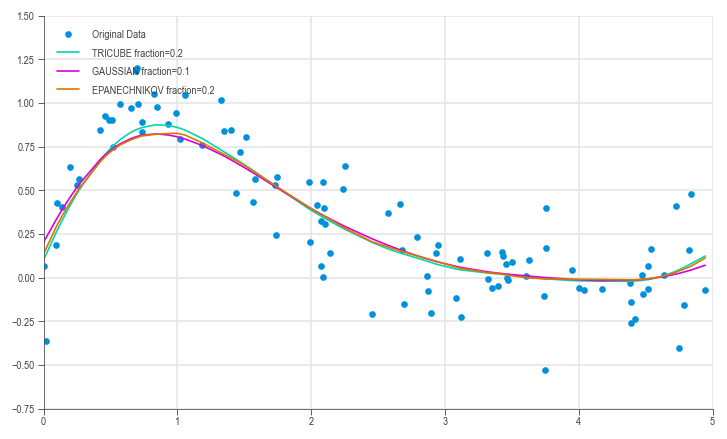

In [2]:
import numpy as np
import daspi as dsp
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)
x=np.sort(5*np.random.random(100))
df = pd.DataFrame(dict(
    x=x,
    y=np.sin(x) * 3*np.exp(-x) + np.random.normal(0, 0.2, 100)))
plt.plot(df.x, df.y, label='Original Data', marker='o', lw=0)

model = dsp.Lowess(df, 'y', 'x')
options = {
    'tricube': 0.2,
    'gaussian': 0.1,
    'epanechnikov': 0.2}
for kernel, fraction in options.items():
    model.fit(fraction, kernel)
    plt.plot(model.x, model.smoothed, label=f'{kernel.upper()} {fraction=}', lw=1)
plt.legend()
plt.show()

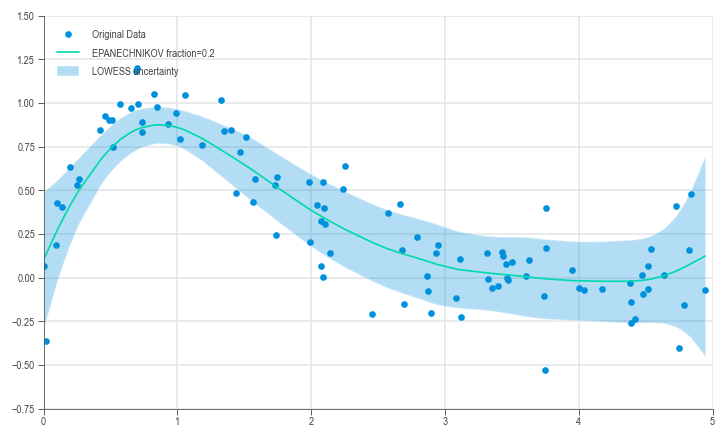

In [5]:
import numpy as np
import daspi as dsp
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)
x=np.sort(5*np.random.random(100))
df = pd.DataFrame(dict(
    x=x,
    y=np.sin(x) * 3*np.exp(-x) + np.random.normal(0, 0.2, 100)))
plt.plot(df.x, df.y, label='Original Data', marker='o', lw=0)

model = dsp.Lowess(df, 'y', 'x')
model.fit(0.2, 'tricube')
plt.plot(model.x, model.smoothed, label=f'{kernel.upper()} {fraction=}', lw=1)
plt.fill_between(
    model.x,
    model.smoothed - 2*model.std_errors,
    model.smoothed + 2*model.std_errors,
    alpha=0.3,
    label='LOWESS uncertainty')
plt.legend()
plt.show()